In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot,add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
%matplotlib inline
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import graphviz
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
from sklearn.decomposition import PCA
warnings.simplefilter('ignore')
matplotlib.rc('font',family = 'AppleGothic')
matplotlib.rc('axes',unicode_minus=False)
import statsmodels.api as sm
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# 로지스틱 회귀분석

## (1) 데이터 구성하기

In [2]:
df_raw=pd.read_csv("/Users/lee/Week3/HMEQ.csv",engine="python",encoding='cp949')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


## (2) 데이터 전처리 (결측치 처리)

In [3]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [4]:
df_raw["JOB"].fillna("Other",inplace=True)
df_raw.fillna(df_raw.mean(),inplace=True)

## (3) 데이터 분할

In [5]:
df_train, df_test = train_test_split(df_raw,test_size=0.3,random_state=1234)
print('train data size:{}'.format(df_train.shape))
print('test data size:{}'.format(df_test.shape))

train data size:(2623, 13)
test data size:(1125, 13)


## (4) 모델 및 회귀계수 검토

In [6]:
log_model=Logit.from_formula("BAD ~ LOAN+MORTDUE+VALUE+C(REASON)+C(JOB)+YOJ+DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC",df_train)
log_result=log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Thu, 20 May 2021   Pseudo R-squ.:                  0.2257
Time:                        11:50:00   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

## (5) 예측 및 성능 평가

In [7]:
y_pred = log_result.predict(df_test)

y_pred_class = (y_pred>0.5).astype(int)
y_pred_class.head()

1721    0
822     0
1686    0
789     0
165     0
dtype: int64

In [8]:
print('Accuracy:{0:.3f}\n'.format(accuracy_score(df_test["BAD"],y_pred_class)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test["BAD"],y_pred_class)))

Accuracy:0.924

Confusion Matrix:
[[1017    4]
 [  81   23]]


## (6) 결론 도출 - 최종 회귀식

<AxesSubplot:>

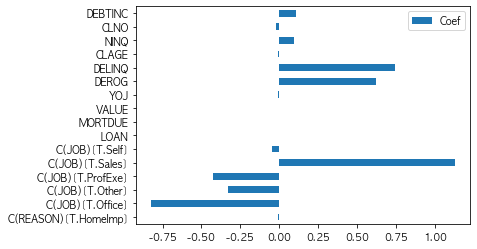

In [9]:
df_logistic_coef=pd.DataFrame({"Coef":log_result.params.values[1:]},index=log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

## (7) 표준화 회귀계수

In [10]:
df_char=df_raw.select_dtypes(include="object")
df_numeric=df_raw.select_dtypes(exclude="object")

scaler=StandardScaler()
np_numeric_scaled=scaler.fit_transform(df_numeric)
df_numeric_scaled=pd.DataFrame(np_numeric_scaled,columns=df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled,df_char],axis=1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


## (7-1) 표준화 회귀계수

In [11]:
df_scaled["BAD"]=np.where(df_scaled["BAD"]>0,1,0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [12]:
df_scaled_train,df_scaled_test = train_test_split(df_scaled,test_size=0.3,random_state=1234)

## (8) 결론 요약

In [13]:
scaled_log_model=Logit.from_formula('BAD ~ LOAN+MORTDUE+VALUE+C(REASON)+C(JOB)+YOJ+DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC',df_scaled_train)

In [14]:
scaled_log_result=scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Thu, 20 May 2021   Pseudo R-squ.:                  0.2257
Time:                        11:50:01   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4815      0.205    -12.111      0.000      -2.883      -2.080

## (9) 표준화 회귀계수

<AxesSubplot:>

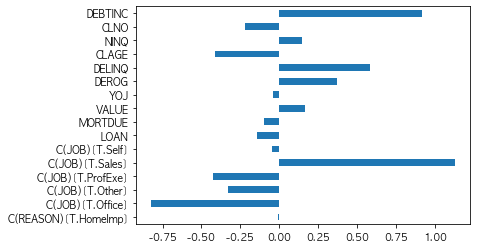

In [17]:
df_log_scaled_coef=pd.DataFrame({"Coef":scaled_log_result.params.values[1:]},index=scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = "Coef",legend=False)